### Import Dependencies

In [416]:
import numpy as np
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno

In [417]:
# Function to read data from source
def get_data(file_name: str) -> pd.DataFrame:
    """
    Load a JSON Lines (.jsonl) file into a pandas DataFrame.

    This function reads newline-delimited JSON (JSONL) files, where each line
    is a valid JSON object.

    Parameters
    ----------
    file_name : str
        Name of the JSONL file located inside the 'data/' directory.

    Returns
    -------
    pd.DataFrame
        A pandas DataFrame containing the parsed JSONL data.
    """
    base_dir: Path = Path.cwd()
    file_path: Path = base_dir / "data" / file_name

    return pd.read_json(
        file_path,
        lines=True,
        convert_dates=False
    )

In [418]:
# Reading data
df = get_data(r'message_dump.jsonl')

In [419]:
# Preview of data
df.head(5)

,message_id,channel_id,author_id,content,created_at,deleted_at,mention_ids,attachment_count
0,msg_1,ch_1,user_1,Hi everyone!👋 I'm a master's thesis worker at ...,1604433640482,NaN,[],0
1,msg_2,ch_1,deleted,"Hey guys, just a hobbyist here interested in A...",1604436819623,NaN,[],0
2,msg_3,ch_1,user_2,"Hi everyone,\n\nI'm a Data Scientist currentlh...",1605229871136,NaN,[],0
3,msg_4,ch_1,user_3,"Hey there, I am a data science enthusiast and ...",1605945403577,NaN,[],0
4,msg_5,ch_1,user_4,Hi guys/gals/orthogonal vectors! I'm an ML Eng...,1606845773752,NaN,[],0


In [420]:
# Shape of data
df.shape

(69052, 8)

In [421]:
# data dtypes of features
df.dtypes

message_id           object
channel_id           object
author_id            object
content              object
created_at            int64
deleted_at          float64
mention_ids          object
attachment_count      int64
dtype: object

### Null values

In [422]:
# Replacing [] with Nan values
df["mention_ids"] = df["mention_ids"].apply(
    lambda x: np.nan if x == [] else x
)

📌 Missing Value Representation – mention_ids

The mention_ids column does not consistently use null values to represent missing data. Instead of NaN, several rows contain empty lists []. This representation masks the true count of missing or absent values when standard null checks are applied.

In [423]:
# Checking for null values
df.isna().sum().to_frame(name="null_count")

,null_count
message_id,0
channel_id,0
author_id,0
content,0
created_at,0
deleted_at,69044
mention_ids,54830
attachment_count,0


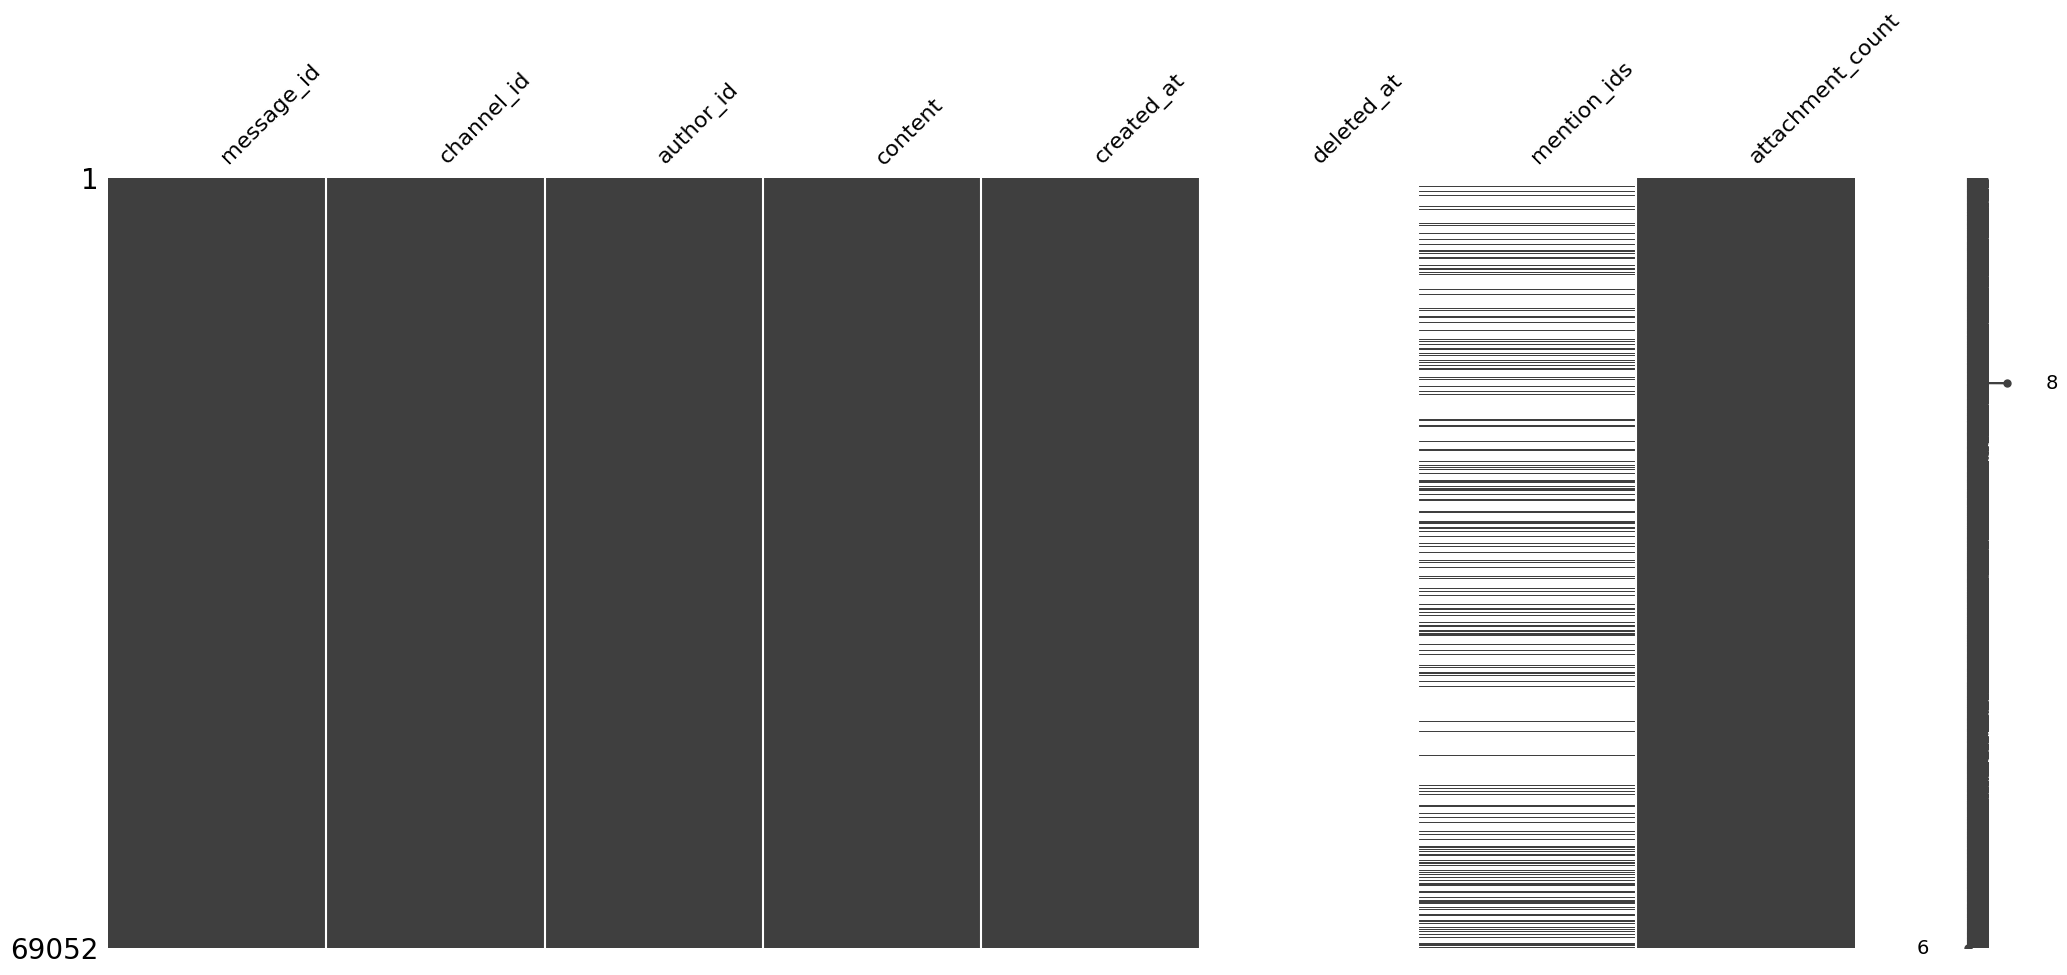

In [424]:
# Matrix plot
msno.matrix(
    df = df,
    label_rotation=45,
    sparkline=True,
)
plt.show()

📌 Missing Value Analysis – Observations

The dataset shows complete data for several core columns, including message_id, channel_id, author_id, content, created_at, and attachment_count, all of which contain zero missing values. This indicates that primary identifiers, timestamps, and content-related fields are consistently recorded.

Missing values are observed in two columns: deleted_at and mention_ids. The deleted_at column contains 69,044 null entries, while mention_ids has 54,830 null entries. Missingness is therefore limited to specific, context-dependent fields rather than being widespread across the dataset.

The presence of null values in mention_ids suggests that a substantial portion of messages do not reference or tag other users. Similarly, the missing values in deleted_at indicate messages that do not have an associated deletion timestamp.

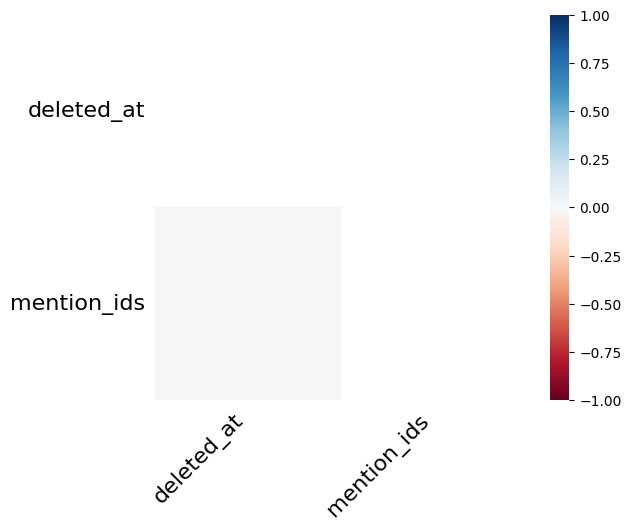

In [425]:
# Heat map
msno.heatmap(
    df, 
    figsize=(6,5), 
    label_rotation=45, 
    labels=True
)
plt.show()

In [426]:
df.head(5)

,message_id,channel_id,author_id,content,created_at,deleted_at,mention_ids,attachment_count
0,msg_1,ch_1,user_1,Hi everyone!👋 I'm a master's thesis worker at ...,1604433640482,NaN,NaN,0
1,msg_2,ch_1,deleted,"Hey guys, just a hobbyist here interested in A...",1604436819623,NaN,NaN,0
2,msg_3,ch_1,user_2,"Hi everyone,\n\nI'm a Data Scientist currentlh...",1605229871136,NaN,NaN,0
3,msg_4,ch_1,user_3,"Hey there, I am a data science enthusiast and ...",1605945403577,NaN,NaN,0
4,msg_5,ch_1,user_4,Hi guys/gals/orthogonal vectors! I'm an ML Eng...,1606845773752,NaN,NaN,0


In [427]:
# type value counts
for col in df.columns:
    if col == 'created_at':
        continue
    print(df[col].apply(type).value_counts(dropna=False))
    print('='*50)

message_id
<class 'str'>    69052
Name: count, dtype: int64
channel_id
<class 'str'>    69052
Name: count, dtype: int64
author_id
<class 'str'>    69052
Name: count, dtype: int64
content
<class 'str'>    69052
Name: count, dtype: int64
deleted_at
<class 'float'>    69052
Name: count, dtype: int64
mention_ids
<class 'float'>    54830
<class 'list'>     14222
Name: count, dtype: int64
attachment_count
<class 'int'>    69052
Name: count, dtype: int64


In [428]:
df.loc[df.mention_ids.apply(type) == list, 'mention_ids']

14         [user_13]
131       [user_118]
141       [user_125]
142       [user_129]
151       [user_134]
            ...     
69033    [user_7936]
69034    [user_1877]
69038    [user_3250]
69048    [user_3271]
69049    [user_2047]
Name: mention_ids, Length: 14222, dtype: object

The coexistence of float and list types within the same column introduces structural inconsistency in the dataset. This inconsistency affects uniform processing of the column, as operations expecting a single data type cannot be applied reliably across all records.

In [429]:
df["mention_ids"] = df["mention_ids"].apply(
    lambda x: x[0] if isinstance(x, list) else x
)

In [430]:
df.mention_ids.apply(type).value_counts()

mention_ids
<class 'float'>    54830
<class 'str'>      14222
Name: count, dtype: int64

In [431]:
# Checking for duplicate instances
df.duplicated().sum()

np.int64(0)

📌 Duplicate values

There are no duplicates in the data which indicates that every row is unique.

In [432]:
# Number of unique values in each feature
for col in df.columns:
    print(f'nunique values in {col}: {df[col].nunique()}')
    print('='*50)

nunique values in message_id: 69052
nunique values in channel_id: 12
nunique values in author_id: 7913
nunique values in content: 61489
nunique values in created_at: 69052
nunique values in deleted_at: 8
nunique values in mention_ids: 3391
nunique values in attachment_count: 8


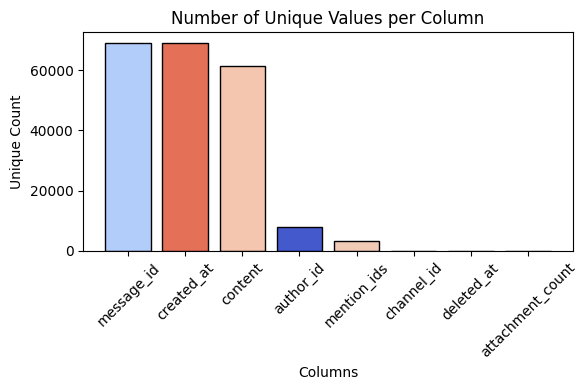

In [433]:
nunique = df.nunique().sort_values(ascending=False)

colors = np.random.rand(len(nunique))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    nunique.index,
    nunique.values,
    edgecolor="black",
    linewidth=1,
    color = plt.cm.coolwarm(colors),
)

ax.set_title("Number of Unique Values per Column")
ax.set_xlabel("Columns")
ax.set_ylabel("Unique Count")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### user_id

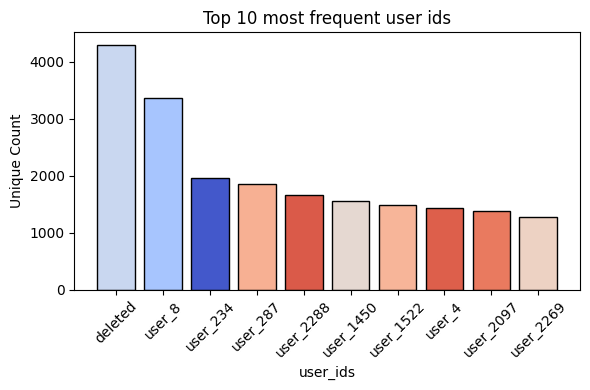

In [434]:
top_user_ids = df.author_id.value_counts().sort_values(ascending=False).nlargest(n=10)

colors = np.random.rand(len(top_user_ids))

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(
    top_user_ids.index,
    top_user_ids.values,
    color = plt.cm.coolwarm(colors),
    edgecolor='black'
)

ax.set_title('Top 10 most frequent user ids')
ax.set_xlabel("user_ids")
ax.set_ylabel("Unique Count")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

### channel_id

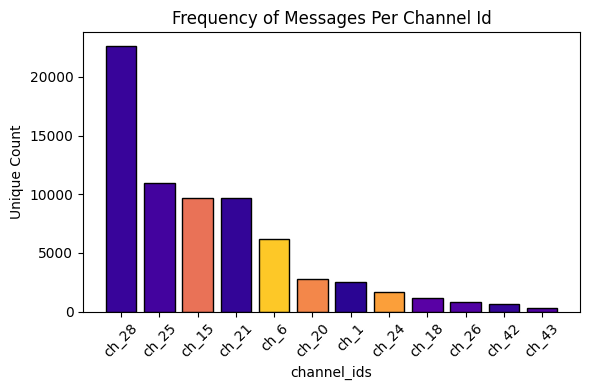

In [435]:
top_channel_id = df.channel_id.value_counts().sort_values(ascending=False)

colors = np.random.rand(len(top_channel_id))

fig, ax = plt.subplots(figsize=(6,4))
ax.bar(
    top_channel_id.index,
    top_channel_id.values,
    color = plt.cm.plasma(colors),
    edgecolor='black'
)

ax.set_title('Frequency of Messages Per Channel Id')
ax.set_xlabel("channel_ids")
ax.set_ylabel("Unique Count")
ax.tick_params(axis="x", rotation=45)

plt.tight_layout()
plt.show()

📌 Message Distribution Across Channels

The distribution of messages across channels is highly uneven. Channel ch_28 has the highest message volume with 22,662 messages, followed by ch_25 with 10,962 messages. Channels ch_15 and ch_21 also show similar activity levels, each contributing just under 10,000 messages.

A noticeable drop in message volume is observed after the top four channels. Channel ch_6 records 6,217 messages, while several other channels contribute fewer than 3,000 messages each. Channels such as ch_1, ch_24, and ch_18 fall into a mid-range activity group with steadily decreasing counts.

The least active channels include ch_26, ch_42, and ch_43, each contributing fewer than 1,000 messages, with ch_43 showing the lowest activity at 278 messages. Overall, a small subset of channels accounts for a disproportionately large share of the total messages, while the majority of channels exhibit comparatively low activity levels.

### attachment_count

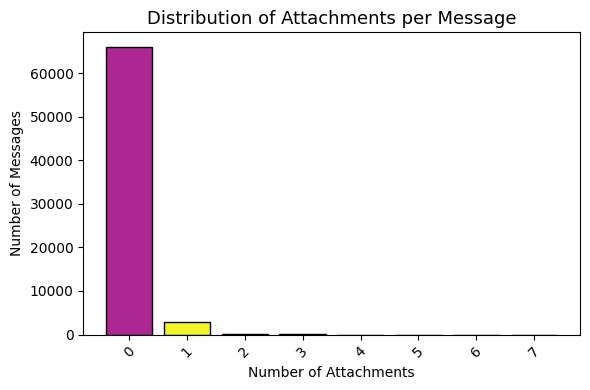

In [436]:
attachment_count = df.attachment_count.value_counts().sort_values(ascending=False)

colors = np.random.rand(len(attachment_count))

fig, ax = plt.subplots(figsize=(6, 4))
ax.bar(
    attachment_count.index,
    attachment_count.values,
    color=plt.cm.plasma(colors),
    edgecolor="black"
)

ax.set_title("Distribution of Attachments per Message", fontsize=13)
ax.set_xlabel("Number of Attachments")
ax.set_ylabel("Number of Messages")

ax.tick_params(axis="x", rotation=45)
plt.tight_layout()
plt.show()

📌 Attachment Count Distribution in Messages

The majority of messages contain no attachments, with 66,069 messages having an attachment_count of zero. This indicates that attachments are not commonly used in most message.

Messages with a single attachment form a much smaller group, totaling 2,822 instances. As the number of attachments increases, the frequency of messages drops sharply. Only 117 messages contain two attachments, and counts beyond this point decrease to a few dozen or single-digit occurrences.

Messages with three or more attachments are rare, with the highest observed attachment count being seven, appearing in only two messages. Overall, the distribution is heavily skewed toward messages without attachments, with multi-attachment messages occurring infrequently across the dataset.

### content

In [448]:
df.loc[df.content == ""]

,message_id,channel_id,author_id,content,created_at,deleted_at,mention_ids,attachment_count
575,msg_576,ch_1,user_496,,1657283797178,NaN,NaN,0
586,msg_587,ch_1,user_496,,1658226655214,NaN,NaN,0
588,msg_589,ch_1,user_496,,1658343647215,NaN,NaN,0
1070,msg_1071,ch_1,user_934,,1695548037765,NaN,NaN,0
1341,msg_1342,ch_1,user_1162,,1714102132923,NaN,NaN,0
...,...,...,...,...,...,...,...,...
68657,msg_68677,ch_42,user_1198,,1717565565104,NaN,NaN,1
68699,msg_68719,ch_42,user_2978,,1729122799610,NaN,NaN,1
68773,msg_68793,ch_42,user_7960,,1768702096776,NaN,NaN,4
68912,msg_68932,ch_43,user_7542,,1745197732000,NaN,NaN,1


In [451]:
df = df.assign(
    content = df.content.apply(lambda x: np.nan if x == "" else x)
)

In [452]:
df.isna().sum()

message_id              0
channel_id              0
author_id               0
content              1601
created_at              0
deleted_at          69044
mention_ids         54830
attachment_count        0
dtype: int64

📌 Empty Content Analysis

An analysis of the content column reveals the presence of 1,601 instances where the message content is an empty string. These entries are not recorded as null values but appear as blank text fields.

This indicates that certain messages exist in the dataset without any textual content while still being represented as valid records. The absence of text is therefore embedded within the data values themselves rather than being reflected through missing value indicators.

Overall, the content column includes a small but notable subset of messages with empty content, which may influence text-based analysis and summary statistics if not explicitly accounted for.

In [455]:
df.content.value_counts()

content
hi                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   154
Hi                                                                                                                                                                     